In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Meshcat url:  http://127.0.0.1:7005/static/


In [3]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "cup": Cup,
        "bowl": Bowl,
        "plate": Plate,
        "bin": DishBin
    }
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

Saving...
Loading...


[2021-09-27 19:51:32.413] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


In [4]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [5]:
observed_node_set_test = [
    Bowl(drake_tf_to_torch_tf(RigidTransform(
        p=[0.5, 0.0, 0.1],
        R=UniformlyRandomRotationMatrix(RandomGenerator(0))))
    ),
    DishBin(drake_tf_to_torch_tf(
        RigidTransform(p=[0.5, 0., 0.]))
    )
]
print([type(node).__name__ for node in observed_node_set_test])

['Bowl', 'DishBin']


In [9]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, observed_node_set_test, N_solutions=5))
vis["parses"].delete()
for k, tree in enumerate(trees):
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)

In [10]:
print(len(trees))

1


# MIPMAP-EM alternation

In [11]:
em = EMWrapper(grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=8)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (Plate): ConstrainedParameter()
    (CupChildObject): ConstrainedParameter()
    (PlateChildObject): ConstrainedParameter()
    (BowlChildObject): ConstrainedParameter()
    (Object): ConstrainedParameter()
    (Bowl): ConstrainedParameter()
    (DishBin): ConstrainedParameter()
    (Cup): ConstrainedParameter()
  )
  (rule_params_by_node_type): ModuleDict(
    (Plate): ModuleList(
      (0): ModuleList(
        (0): ModuleDict(
          (mean): ConstrainedParameter()
          (variance): ConstrainedParameter()
        )
        (1): ModuleDict(
          (M): ConstrainedParameter()
          (Z): ConstrainedParameter()
        )
      )
    )
    (CupChildObject): ModuleList(
      (0): ModuleList(
        (0): ModuleDict()
        (1): ModuleDict()
      )
      (1): ModuleList(
        (0): ModuleDict()
        (1): ModuleDict()
      )
      (2): ModuleList(
        (0): ModuleDict()
        (1): ModuleDict()
      )
 

Final params:  tensor([0.5250])
mean tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0231,  0.0264,  0.0512],
        [-0.0224,  0.0293,  0.0435],
        [-0.0192,  0.0288,  0.0413],
        [-0.0206,  0.0395,  0.0425],
        [-0.0213,  0.0261,  0.0446],
        [-0.0260,  0.0358,  0.0485],
        [-0.0194,  0.0027,  0.0523],
        [-0.0213,  0.0139,  0.0474],
        [-0.0266,  0.0177,  0.0470],
        [-0.0316,  0.0235,  0.0448]])
0:xyz:mean final: tensor([-0.0316,  0.0235,  0.0448])
variance tensor([[0.2000, 0.2000, 0.2000],
        [0.0064, 0.0275, 0.0018],
        [0.0045, 0.0261, 0.0011],
        [0.0042, 0.0262, 0.0011],
        [0.0043, 0.0260, 0.0012],
        [0.0044, 0.0252, 0.0016],
        [0.0044, 0.0252, 0.0017],
        [0.0061, 0.0205, 0.0014],
        [0.0054, 0.0253, 0.0012],
        [0.0049, 0.0238, 0.0012],
        [0.0048, 0.0237, 0.0012]])
0:xyz:variance final: tensor([0.0048, 0.0237, 0.0012])
0:rot:M final: tensor([[-0.0435,  0.0404,  0.2907,  0.9550],
 

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:767: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


Bowl
Final params:  tensor([0.0001])
mean tensor([[ 0.0500,  0.0500,  0.0500],
        [ 0.0194,  0.0063,  0.0373],
        [-0.0001,  0.0086,  0.0456],
        [-0.0146,  0.0068,  0.0562],
        [-0.0205,  0.0011,  0.0646],
        [-0.0097, -0.0137,  0.0683],
        [-0.0099, -0.0140,  0.0683],
        [-0.0099, -0.0140,  0.0683],
        [-0.0099, -0.0140,  0.0683],
        [-0.0099, -0.0140,  0.0683],
        [-0.0099, -0.0140,  0.0683]])
0:xyz:mean final: tensor([-0.0099, -0.0140,  0.0683])
variance tensor([[1.0000e-02, 1.0000e-02, 1.0000e-02],
        [1.3202e-03, 1.3418e-03, 2.3110e-03],
        [9.3876e-04, 5.8705e-04, 1.4231e-03],
        [1.2630e-03, 7.0845e-04, 2.6007e-04],
        [1.0588e-03, 8.2613e-04, 5.5021e-05],
        [6.5918e-05, 4.5937e-04, 1.0000e-06],
        [6.3653e-05, 4.5723e-04, 1.0000e-06],
        [6.3653e-05, 4.5723e-04, 1.0000e-06],
        [6.3653e-05, 4.5723e-04, 1.0000e-06],
        [6.3653e-05, 4.5723e-04, 1.0000e-06],
        [6.3653e-05, 4.5723

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:767: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


Final params:  tensor([0.8719])
mean tensor([[ 0.0500,  0.0500,  0.0500],
        [ 0.0507,  0.0368,  0.0135],
        [ 0.0596,  0.0402,  0.0256],
        [ 0.0544,  0.0367,  0.0285],
        [ 0.0599,  0.0058,  0.0290],
        [ 0.0253,  0.0166,  0.0048],
        [ 0.0252,  0.0230, -0.0114],
        [-0.0053,  0.0475, -0.0168],
        [ 0.0055,  0.0178, -0.0111],
        [ 0.0045,  0.0135, -0.0132],
        [ 0.0087,  0.0305, -0.0084]])
0:xyz:mean final: tensor([ 0.0087,  0.0305, -0.0084])
variance tensor([[0.0100, 0.0100, 0.0100],
        [0.0121, 0.0095, 0.0039],
        [0.0130, 0.0156, 0.0030],
        [0.0136, 0.0183, 0.0026],
        [0.0132, 0.0319, 0.0025],
        [0.0188, 0.0403, 0.0035],
        [0.0166, 0.0500, 0.0045],
        [0.0178, 0.0814, 0.0039],
        [0.0174, 0.0579, 0.0039],
        [0.0164, 0.0648, 0.0041],
        [0.0162, 0.0647, 0.0039]])
0:xyz:variance final: tensor([0.0162, 0.0647, 0.0039])
0:rot:M final: tensor([[-0.3643,  0.2152,  0.7450,  0.5158],
 

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:767: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


Final params:  tensor([0.2867])
mean tensor([[ 0.0500,  0.0500,  0.0500],
        [ 0.0102,  0.0184,  0.0350],
        [-0.0002,  0.0061,  0.0375],
        [-0.0036,  0.0038,  0.0350],
        [-0.0077,  0.0035,  0.0348],
        [-0.0033,  0.0054,  0.0367],
        [-0.0049,  0.0079,  0.0385],
        [-0.0154,  0.0518,  0.0192],
        [-0.0241,  0.0455,  0.0133],
        [-0.0201,  0.0472,  0.0061],
        [-0.0206,  0.0399,  0.0113]])
0:xyz:mean final: tensor([-0.0206,  0.0399,  0.0113])
variance tensor([[0.0100, 0.0100, 0.0100],
        [0.0018, 0.0035, 0.0024],
        [0.0009, 0.0009, 0.0021],
        [0.0006, 0.0005, 0.0022],
        [0.0007, 0.0004, 0.0024],
        [0.0007, 0.0005, 0.0022],
        [0.0006, 0.0007, 0.0031],
        [0.0010, 0.0074, 0.0022],
        [0.0011, 0.0071, 0.0020],
        [0.0013, 0.0057, 0.0022],
        [0.0017, 0.0046, 0.0024]])
0:xyz:variance final: tensor([0.0017, 0.0046, 0.0024])
0:rot:M final: tensor([[-0.0987, -0.1255,  0.9093,  0.3843],
 

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:767: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


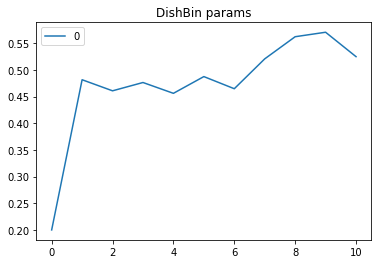

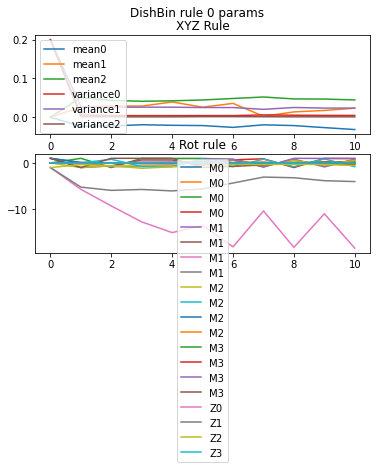

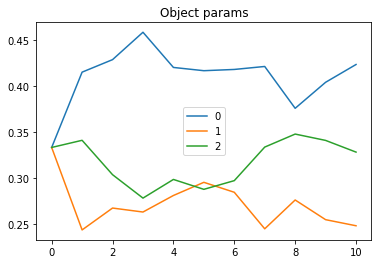

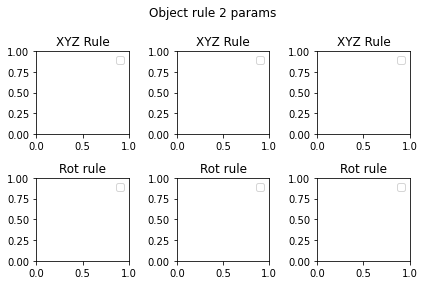

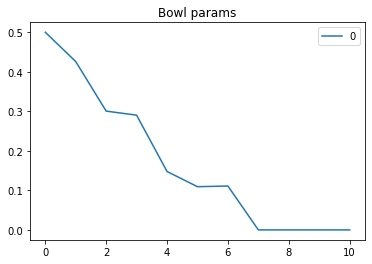

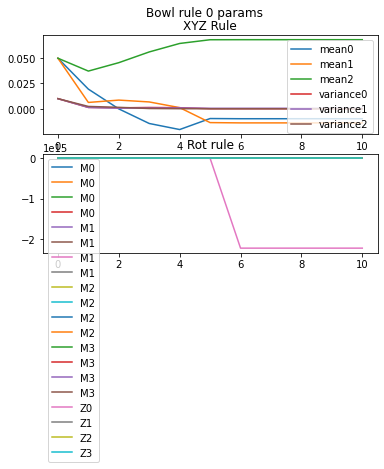

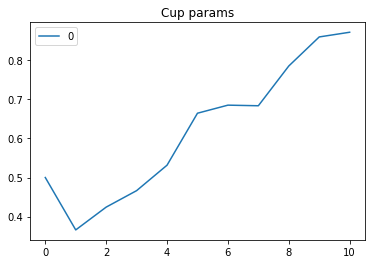

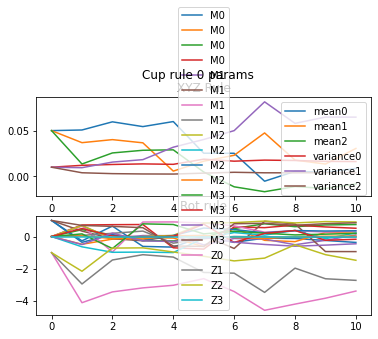

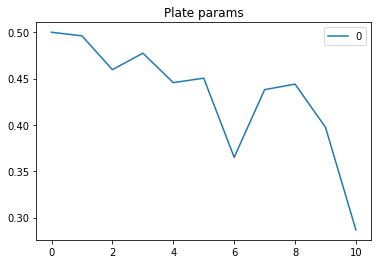

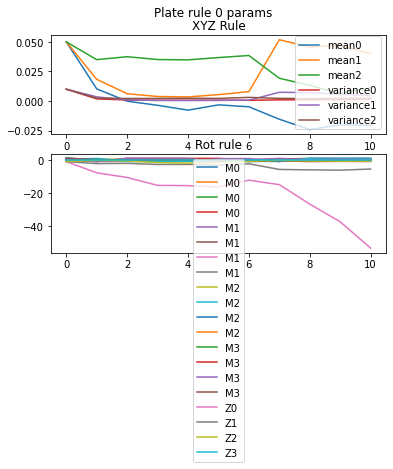

In [13]:
em.plot_grammar_parameter_history(DishBin)
em.plot_grammar_parameter_history(Object)
print("Bowl")
em.plot_grammar_parameter_history(Bowl)
print("Cup")
em.plot_grammar_parameter_history(Cup)
print("Plate")
em.plot_grammar_parameter_history(Plate)

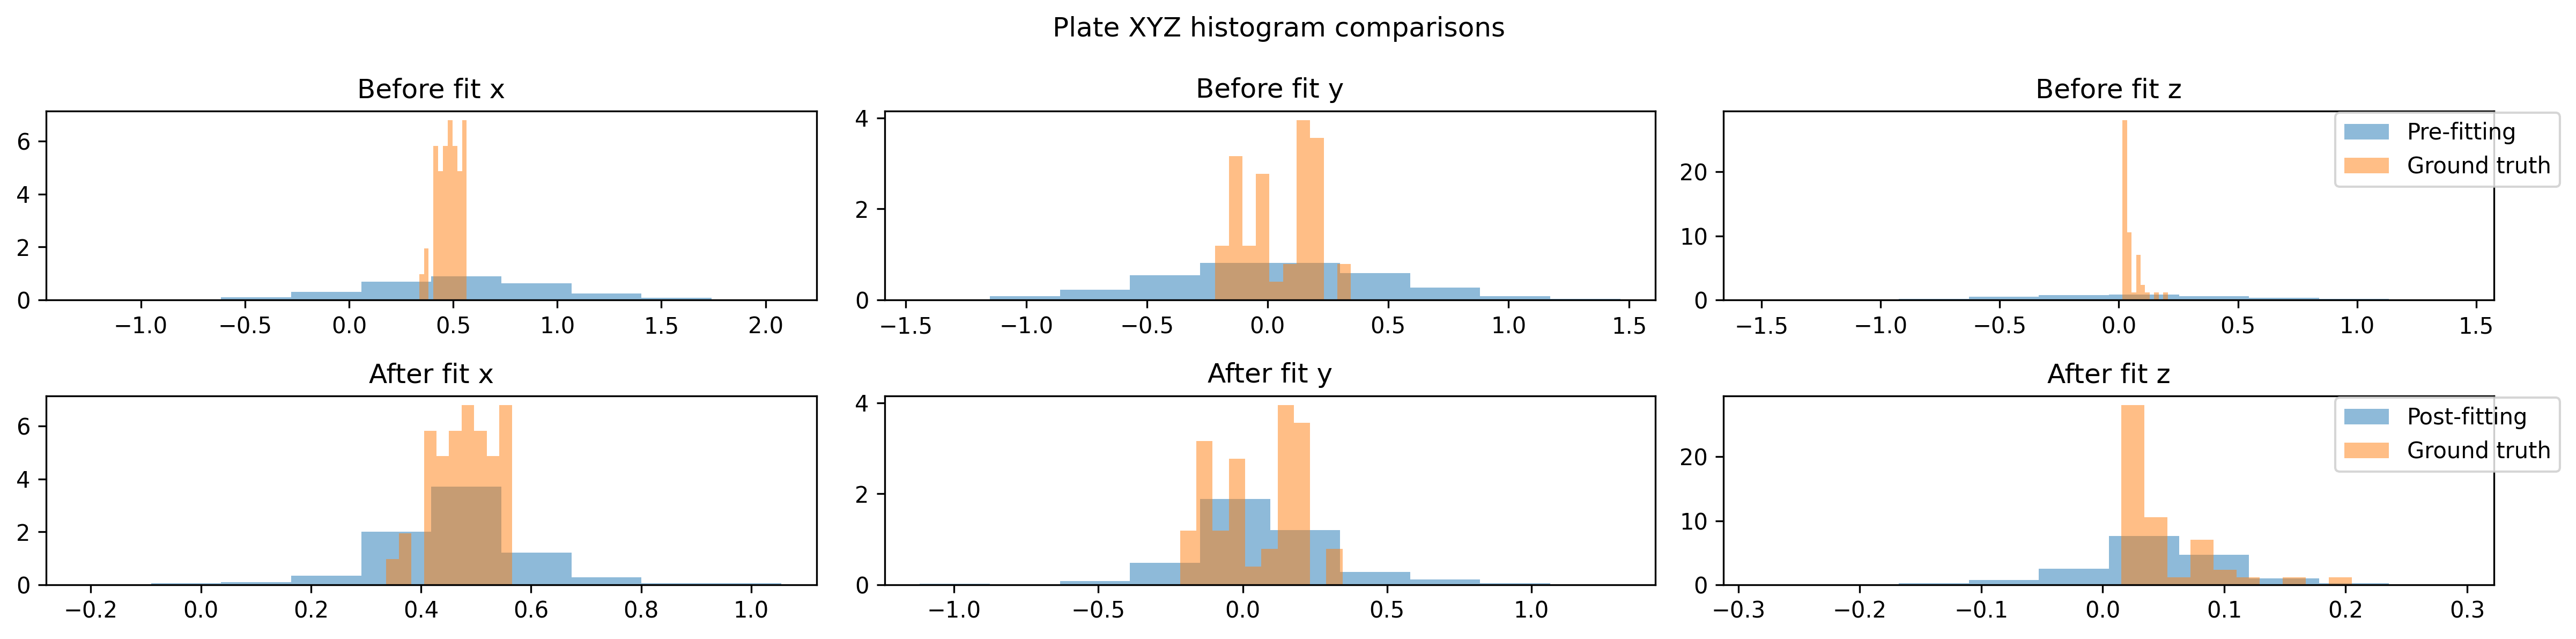

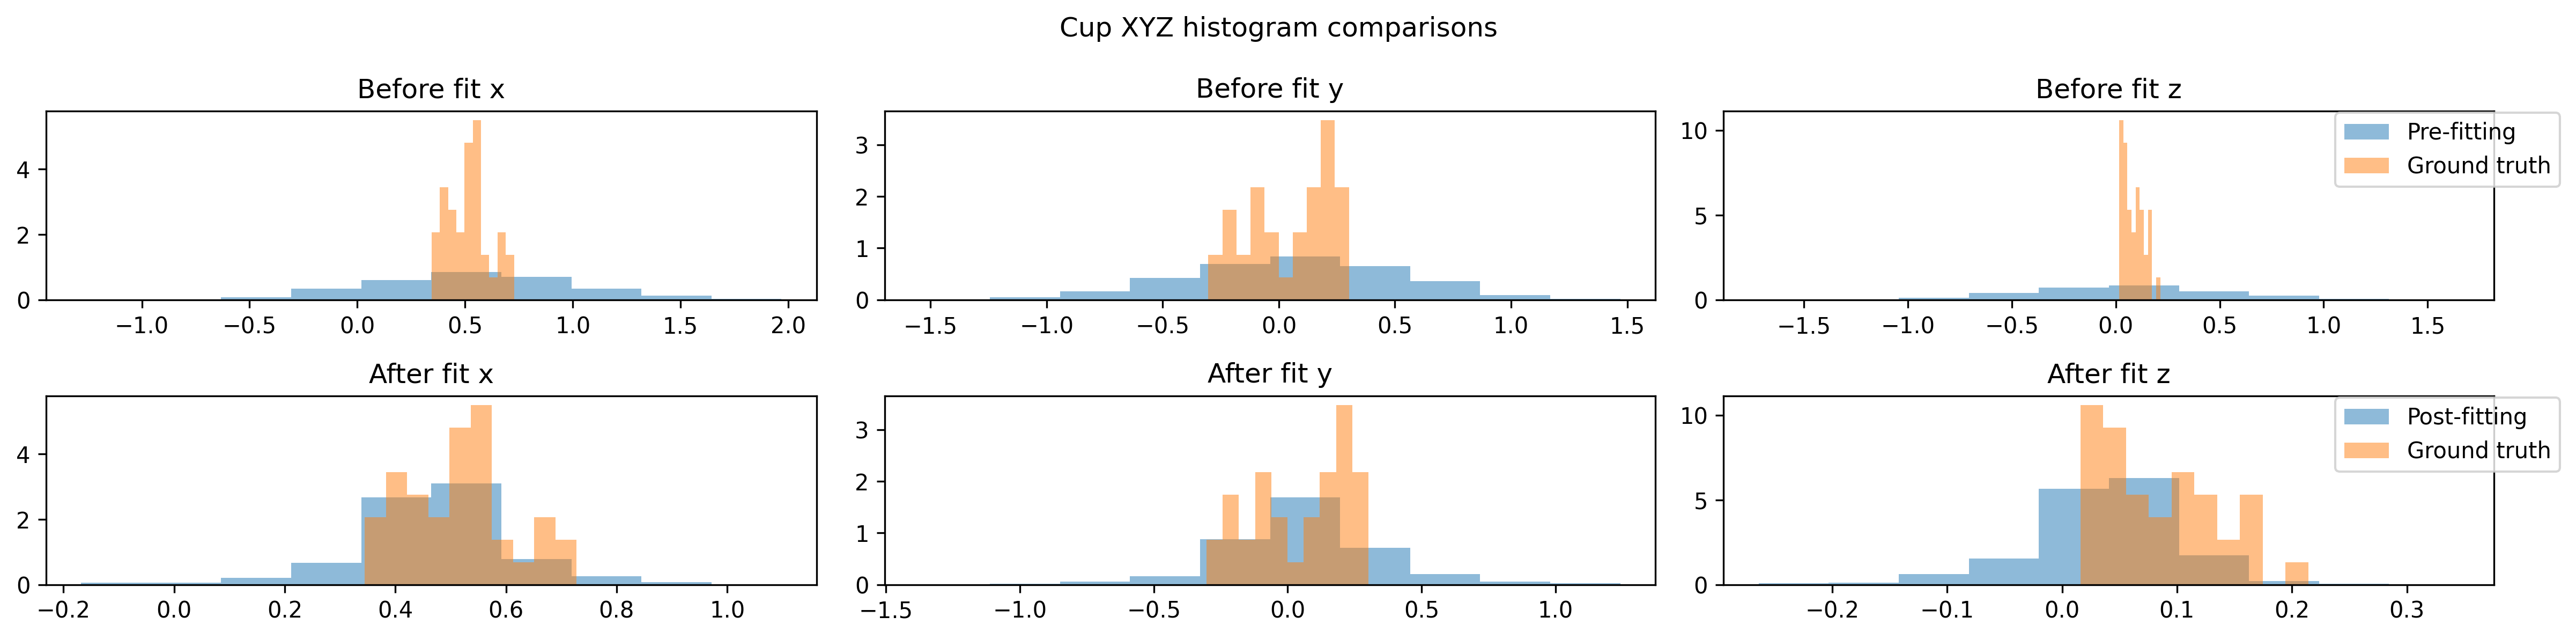

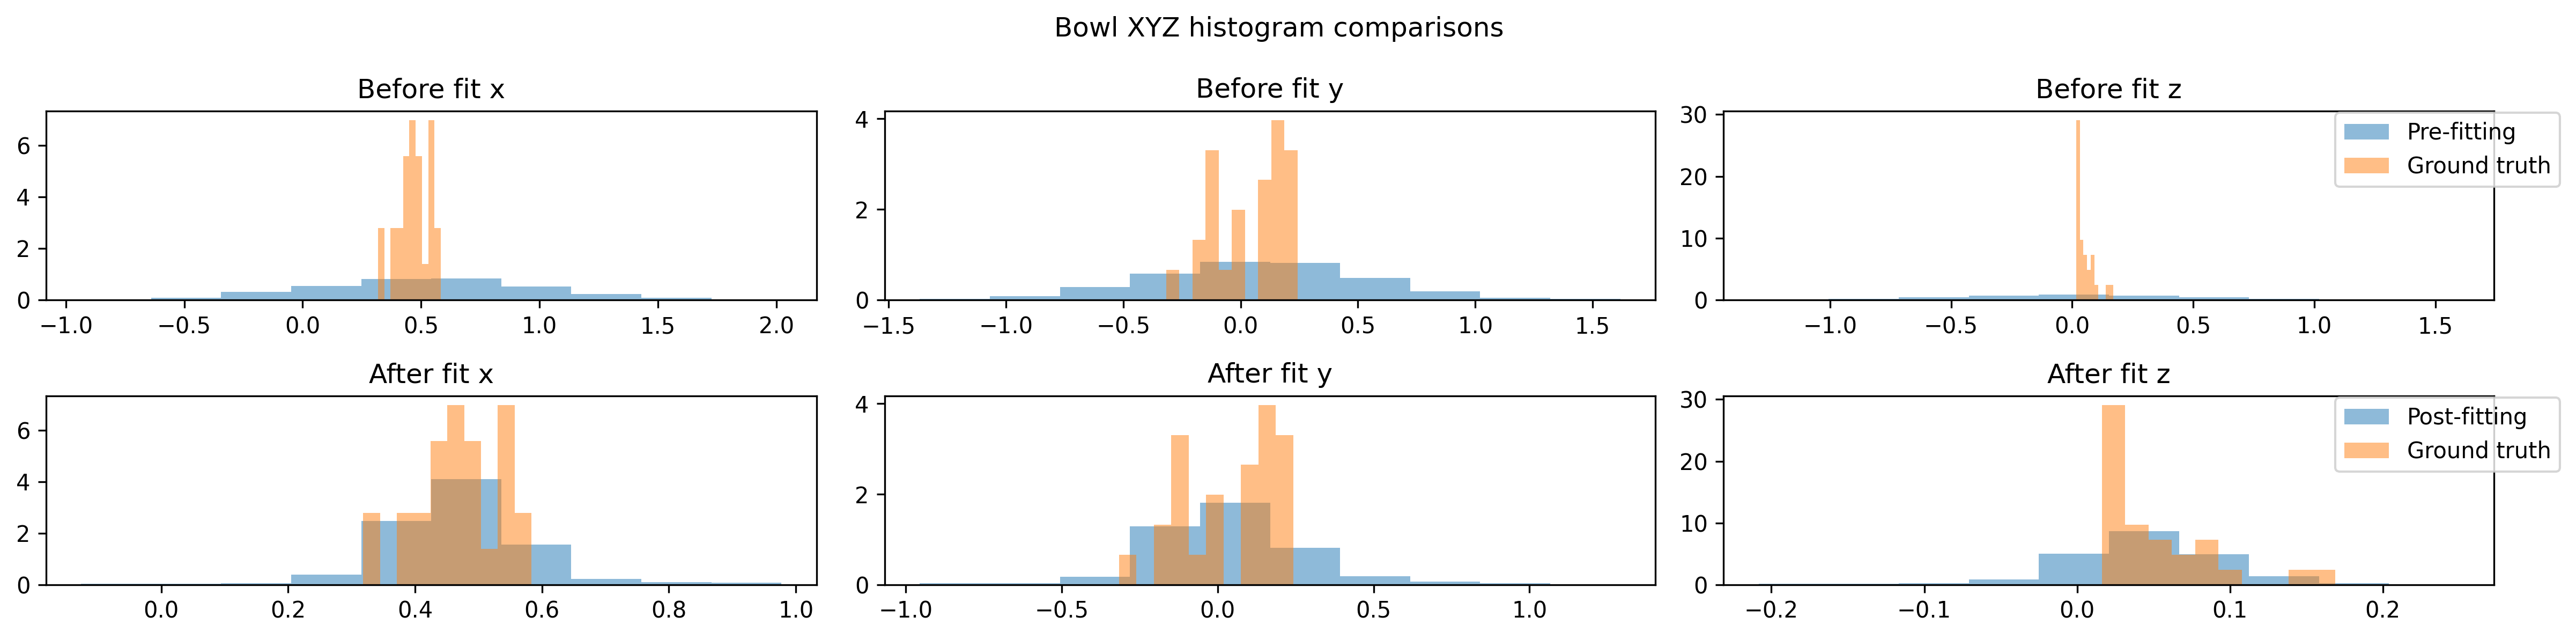

In [14]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [Plate, Cup, Bowl]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [15]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)